In [5]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
from PIL import Image


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_set = FashionMNIST('root', train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

test_set = FashionMNIST('root', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)




In [7]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1, 12, 5), # New dims => (12, 26, 26)
        nn.ReLU(),
        nn.MaxPool2d(2,2), # new dims = (12, 13,13)
        nn.Conv2d(12, 24, 5), # new dims = (24, 11, 11)
        nn.ReLU(),
        nn.MaxPool2d(2,2), # new dims = (24, 6,6) rounded off to 6
        nn.Flatten(),
        nn.Linear(24*4*4, 120),
        nn.ReLU(),
        nn.Linear(120, 60),
        nn.ReLU(),
        nn.Linear(60, 10)
    )

  def forward(self, X):
    logits = self.model(X)
    return logits


model = NeuralNetwork()#.to('cuda')

cost_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [8]:

epochs = 20

for epoch in range(epochs):
  running_loss = 0.0

  for i, data in enumerate(train_loader):
    image, labels = data
    #image, labels = image.to('cuda'), labels.to('cuda')


    optimizer.zero_grad()
    outputs = model(image)
    loss = cost_function(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  avg_loss = running_loss / len(train_loader)
  print(f"Epoch: {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

  torch.save(model.state_dict(), 'FashionMNIST.pth')

Epoch: 1/20, Loss: 0.5410
Epoch: 2/20, Loss: 0.3406
Epoch: 3/20, Loss: 0.2927
Epoch: 4/20, Loss: 0.2671
Epoch: 5/20, Loss: 0.2459
Epoch: 6/20, Loss: 0.2288
Epoch: 7/20, Loss: 0.2159
Epoch: 8/20, Loss: 0.2049
Epoch: 9/20, Loss: 0.1938
Epoch: 10/20, Loss: 0.1845
Epoch: 11/20, Loss: 0.1770
Epoch: 12/20, Loss: 0.1672
Epoch: 13/20, Loss: 0.1600
Epoch: 14/20, Loss: 0.1538
Epoch: 15/20, Loss: 0.1483
Epoch: 16/20, Loss: 0.1437
Epoch: 17/20, Loss: 0.1378
Epoch: 18/20, Loss: 0.1323
Epoch: 19/20, Loss: 0.1258
Epoch: 20/20, Loss: 0.1228


In [9]:
model = NeuralNetwork()
model.load_state_dict(torch.load('FashionMNIST.pth'))

total_correct = 0
total_samples = 0
total_loss = 0

model.eval()
with torch.no_grad():

  for i, data in enumerate(test_loader):
    image, labels =  data
    outputs = model(image)
    loss = cost_function(outputs, labels)

    total_loss += loss.item()
    _,predicted = torch.max(outputs, 1)
    total_correct += (predicted == labels).sum().item()
    total_samples +=  labels.size(0)


  average_loss = total_loss/ len(test_loader)
  average_accuracy = 100 * total_correct / total_samples

  print(f"Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}")



<ipython-input-9-5793b89a02c5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FashionMNIST.pth'))


Loss: 0.3369, Accuracy: 89.7900


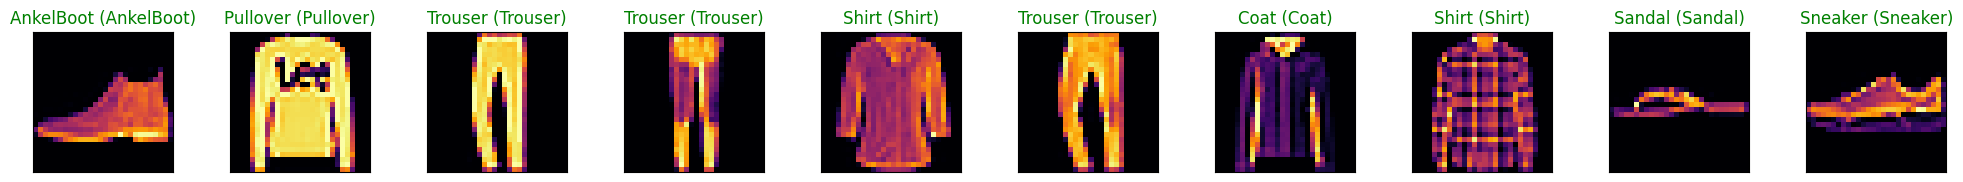

In [10]:
import numpy as np
classes = ['T-Shirt',
                   'Trouser',
                   'Pullover',
                   'Dress',
                   'Coat',
                   'Sandal',
                   'Shirt',
                   'Sneaker',
                   'Bag',
                   'AnkelBoot'
                   ]

dataiter = iter(test_loader)
images, labels = next(dataiter)
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze(), cmap='inferno')
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))